In [1]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from random import uniform

%matplotlib inline
%load_ext autoreload
%autoreload 2

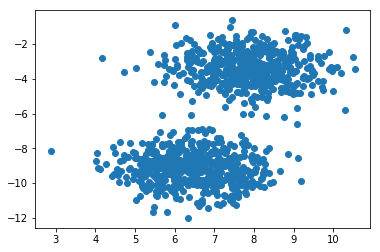

In [80]:
X, _= make_blobs(n_samples=1000, centers=2, n_features=2,
                   random_state=6)
df = pd.DataFrame(X, columns=['x','y'])
plt.scatter(X[:,0],X[:,1])

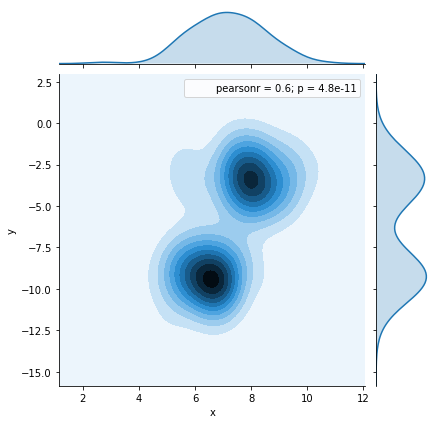

In [3]:
sns.jointplot(x="x", y="y", data=df, kind="kde");

In [4]:
class Gaussian:
    "Model for multivariate Gaussian"
    def __init__(self, mu, sigma, eps = 1e-7):
        self.mu = mu
        self.sigma = sigma
        self.eps = eps
        
    "PDF"
    def pdf(self, x):
        diff = x - self.mu
        dim = len(self.mu)
        sign, det = np.linalg.slogdet(self.sigma)
        det_half = (sign * np.exp(det) + self.eps)  ** 0.5
        inv = np.linalg.pinv(self.sigma)
        return (1./(2 * np.pi) ** (dim/2) * det_half) * np.exp(-1/2 * np.dot(np.dot(diff.T, inv), diff))
    
    def __repr__(self):
        return 'Gaussian mu={:.4}'.format(self.mu)

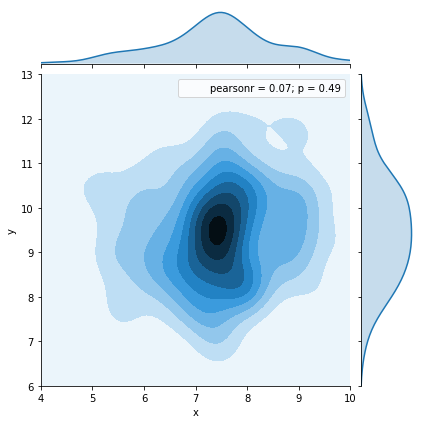

In [5]:
test_gaussian, _= make_blobs(n_samples=100, centers=1, n_features=2,
                   random_state=8)
df_test = pd.DataFrame(test_gaussian, columns=['x','y'])
sns.jointplot(x="x", y="y", data=df_test, kind="kde",xlim=[4,10], ylim=[6,13]);

In [35]:
mu = df_test.mean().as_matrix()
sigma = np.linalg.cholesky(df_test.cov().as_matrix())
gaus = Gaussian(mu, sigma)

In [36]:
M = 100
X_grid = np.linspace(4,10, M)
Y_grid = np.linspace(6,13,M)
X_plot, Y_plot = np.meshgrid(X_grid, Y_grid)

In [37]:
Z = np.zeros(( M, M))
for i, x_val in enumerate(X_grid):
    for j, y_val in enumerate(Y_grid):
        Z[i,j] = gaus.pdf(np.array([x_val, y_val]))

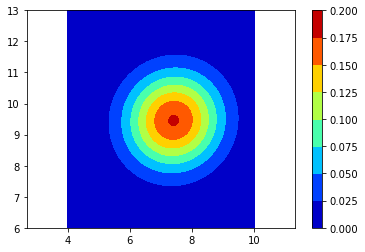

In [38]:
cmap = plt.cm.get_cmap("jet")
cmap.set_over('grey')
cl = plt.contourf(X_plot, Y_plot, Z.T,cmap=cmap)
plt.axis('equal')
plt.colorbar(cl)

$$
x \sim \theta\mathcal{N}(\mu_1, \Sigma_1) + (1-\theta)\mathcal{N}(\mu_2, \Sigma_1) \\
\log{(l(x|\theta, \mu_1, \Sigma_1, \mu_2, \Sigma_1))} = \log
$$

In [73]:
class GaussianMixed:
    def __init__(self, data, sigma_min=0.5, sigma_max=1, mix=.5):
        self.data = data
        mu_min_1=np.min(data[:,0])
        mu_max_1=np.max(data[:,0])
        mu_min_2=np.min(data[:,1])
        mu_max_2=np.max(data[:,1])
        print(mu_min_1, mu_min_2)
        self.one = Gaussian(np.array([uniform(mu_min_1, mu_max_1),uniform(mu_min_2, mu_max_2)]), 
                            uniform(sigma_min, sigma_max) * np.eye(2))
        self.two = Gaussian(np.array([uniform(mu_min_1, mu_max_1),uniform(mu_min_2, mu_max_2)]), 
                            uniform(sigma_min, sigma_max) * np.eye(2))
        
        self.mix = mix
    
    def Estep(self):
        
        self.loglike = 0
        for datum in self.data:
            # Unnormalized
            w1 = self.one.pdf(datum) * self.mix
            w2 = self.two.pdf(datum) * (1 - self.mix)
            
            # log-likelyhood
            self.loglike = np.log(w1 + w2)
            
            # Denominator
            den = w1 + w2
            
            # Normalized
            w1 /= den
            w2 /= den
            
            yield (w1, w2)
            
    def Mstep(self, weights):
        (l, r) = zip(*weights)
        l, r = np.array(l), np.array(r)
        
        one_den = np.sum(l)
        two_den = np.sum(r)
        
        #print(one_den, two_den, self.loglike)
        self.mix = one_den / len(self.data)
        
        self.one.mu = np.sum(self.data.T * l, axis=1) / one_den
        self.two.mu = np.sum(self.data.T * r, axis=1) / two_den
        
        l_diff = self.data - self.one.mu
        r_diff = self.data - self.two.mu
        self.one.sigma = np.linalg.cholesky(np.dot(l_diff.T * l, l_diff) / one_den)
        self.two.sigma = np.linalg.cholesky(np.dot(r_diff.T * r, r_diff) / two_den)
        
        
    def pdf(self, x):
        return self.mix * self.one.pdf(x) + (1 - self.mix) * self.two.pdf(x)
    
    def iterate(self, N=1, verbose=False):
        for i in range(N):
            weights = list(self.Estep())
            self.Mstep(weights)
            print("Iterate {} - mixed: {:.4}, log-likely: {:.4}".format(i+1, self.mix, self.loglike))

In [84]:
gaus_mix = GaussianMixed(X)
gaus_mix.iterate(20)
gaus_mix.mix

2.8747881244990348 -11.996126464107624
Iterate 1 - mixed: 0.8234, log-likely: -28.45
Iterate 2 - mixed: 0.8217, log-likely: -2.127
Iterate 3 - mixed: 0.7957, log-likely: -2.116
Iterate 4 - mixed: 0.7612, log-likely: -2.088
Iterate 5 - mixed: 0.7171, log-likely: -2.056
Iterate 6 - mixed: 0.66, log-likely: -2.027
Iterate 7 - mixed: 0.59, log-likely: -2.025
Iterate 8 - mixed: 0.5285, log-likely: -2.128
Iterate 9 - mixed: 0.5054, log-likely: -2.485
Iterate 10 - mixed: 0.5007, log-likely: -2.802
Iterate 11 - mixed: 0.4999, log-likely: -2.877
Iterate 12 - mixed: 0.4998, log-likely: -2.888
Iterate 13 - mixed: 0.4998, log-likely: -2.89
Iterate 14 - mixed: 0.4998, log-likely: -2.89
Iterate 15 - mixed: 0.4998, log-likely: -2.89
Iterate 16 - mixed: 0.4998, log-likely: -2.89
Iterate 17 - mixed: 0.4998, log-likely: -2.89
Iterate 18 - mixed: 0.4998, log-likely: -2.89
Iterate 19 - mixed: 0.4998, log-likely: -2.89
Iterate 20 - mixed: 0.4998, log-likely: -2.89


0.4997636639322644

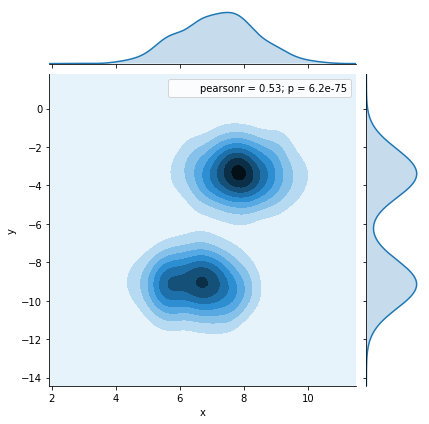

In [82]:
sns.jointplot(x="x", y="y", data=df, kind="kde");

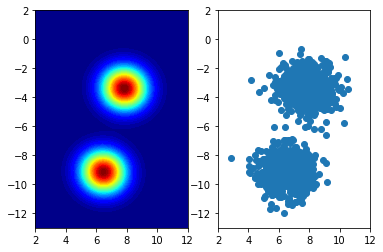

In [85]:
M = 100
X_grid = np.linspace(2,12, M)
Y_grid = np.linspace(-13,2,M)
X_plot, Y_plot = np.meshgrid(X_grid, Y_grid)

Z = np.zeros((M, M))
for i, x_val in enumerate(X_grid):
    for j, y_val in enumerate(Y_grid):
        Z[i,j] = gaus_mix.pdf(np.array([x_val, y_val]))
        
figs, axes = plt.subplots(1,2)
level = np.linspace(0, np.max(Z), 50)        
cmap = plt.cm.get_cmap("jet")
cmap.set_over('grey')
cl = axes[0].contourf(X_plot, Y_plot, Z.T,level, cmap=cmap)
axes[1].scatter(X[:,0],X[:,1])
axes[0].set_xlim([2,12])
axes[1].set_xlim([2,12])
axes[0].set_ylim([-13,2])
axes[1].set_ylim([-13,2])
plt.show()